## Exploring and predicting apartment rental prices

In [3]:
#imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.geodesic
import cartopy.crs as ccrs
import seaborn as sn
import pandas as pd
import geopy.distance
import shapely.geometry
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor


In [46]:
#read and see the data from scraping.py
df = pd.read_csv('flats.csv', )
df = df.drop(columns=['name'])
df.head(10)

,Unnamed: 0,price,lat,long,rooms,size
0,0,1400,51.110245,17.040133,1.0,25.0
1,1,2500,51.102405,17.042242,3.0,74.0
2,2,3600,51.102405,17.042242,2.0,48.0
3,3,2200,51.102405,17.042242,2.0,48.0
4,4,2400,51.102405,17.042242,NaN,NaN
5,5,2300,51.102405,17.042242,2.0,50.0
6,6,2800,51.102405,17.042242,3.0,50.0
7,7,2000,51.104828,17.050008,1.0,65.0
8,8,1200,51.110235,17.048821,1.0,28.0
9,9,1700,51.103239,17.043343,2.0,40.0


In [47]:
#remove rows with missing values
print(df.isna().sum())
print('\ndf shape before removing missing values: {}'.format(df.shape))
df = df.dropna()
print('df shape after removing missing values: {}'.format(df_filtered.shape))

Unnamed: 0     0
price          0
lat            0
long           0
rooms         24
size           8
dtype: int64

df shape before removing missing values: (971, 6)
df shape after removing missing values: (940, 7)


In [48]:
df['price'].describe()

count      940.000000
mean      2295.336170
std       1244.306296
min        200.000000
25%       1700.000000
50%       2000.000000
75%       2500.000000
max      12000.000000
Name: price, dtype: float64

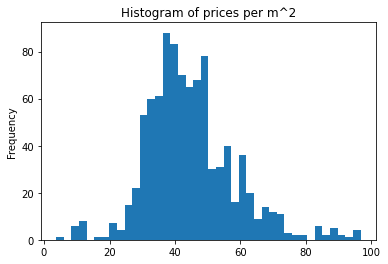

In [49]:
#we will predict price per square meter
df['price/size'] = df.apply(lambda x: x['price'] / x['size'], axis=1)
df_price = df.drop(columns=['price', 'Unnamed: 0'])

df_price = df_price[df_price['price/size'] < 100]
df_price['price/size'].plot.hist(bins=40)
plt.title('Histogram of prices per m^2')
plt.show()

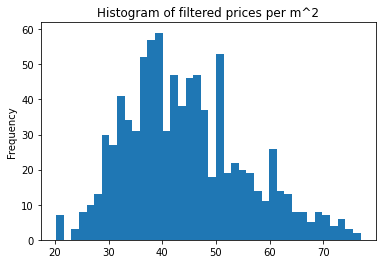

In [50]:
#remove outliers
df_cut = df_price[df_price['price/size'] > 20]
df_cut = df_cut[df_cut['price/size'] < 80]
df_cut['price/size'].plot.hist(bins=40)
plt.title('Histogram of filtered prices per m^2')
plt.show()

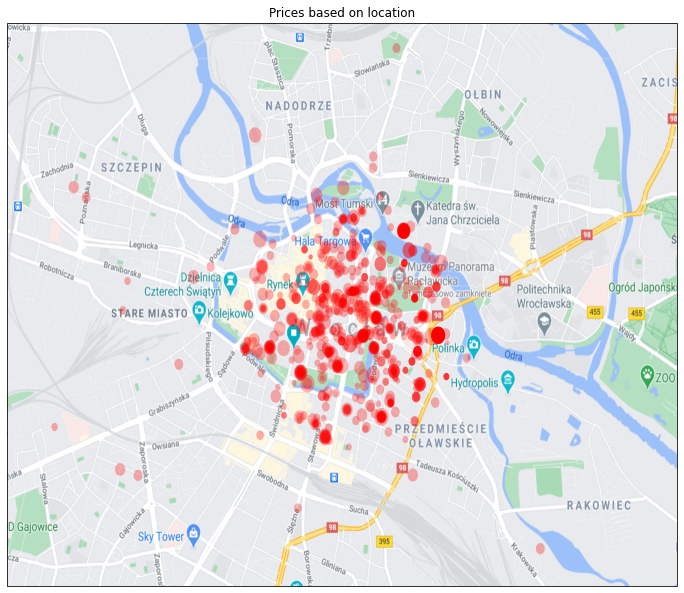

In [51]:
#show data on a map
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Prices based on location')

#show image background
img_extent = (16.997416, 17.105600, 51.092244, 51.126107)
img = plt.imread('img/wroclaw.png')
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

#plot circles
for index, row in df_cut.iterrows():
    circle_points = cartopy.geodesic.Geodesic().circle(lon=row['long'],
                                                       lat=row['lat'],
                                                       radius=row['price/size']*0.8,
                                                       n_samples=20,
                                                       endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='red', edgecolor='none', linewidth=0, alpha=0.3)

ax.set_aspect(1587.0/797)
ax.set_extent((16.997416, 17.077600, 51.092244, 51.126107), crs=ccrs.PlateCarree())
plt.show()

In [52]:
#calculate distances from important locations  

#dictionary of geo-coordinates of important locations 
places = {
    'city_center': (51.1100686, 17.0319407),
    'railway_station': (51.099627, 17.032973),
    'pwr': (51.1073415, 17.0596074),
    'uwr': (51.1140053, 17.0322743),
    'ue': (51.0904575, 17.0222728),
    'awf': (51.1176873, 17.0864211),
}

for place_name, place_location in places.items():
    df_cut['distance_' + place_name] = df_cut.apply(lambda x:geopy.distance.distance(
        (x['lat'], x['long']), place_location).km,
                               axis=1)
    
df_cut.head()    

,lat,long,rooms,size,price/size,distance_city_center,distance_railway_station,distance_pwr,distance_uwr,distance_ue,distance_awf
0,51.110245,17.040133,1.0,25.0,56.000000,0.574053,1.283296,1.401588,0.691281,2.532014,3.345425
1,51.102405,17.042242,3.0,74.0,33.783784,1.116877,0.719053,1.334502,1.467243,1.929649,3.530289
2,51.102405,17.042242,2.0,48.0,75.000000,1.116877,0.719053,1.334502,1.467243,1.929649,3.530289
3,51.102405,17.042242,2.0,48.0,45.833333,1.116877,0.719053,1.334502,1.467243,1.929649,3.530289
5,51.102405,17.042242,2.0,50.0,46.000000,1.116877,0.719053,1.334502,1.467243,1.929649,3.530289


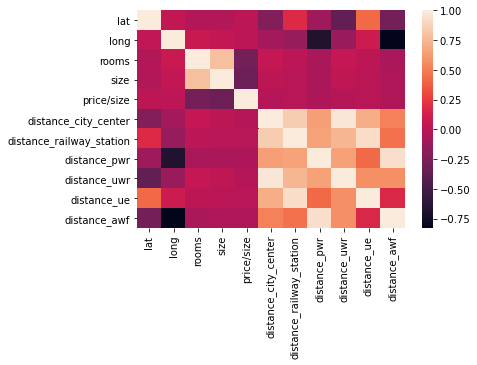

In [53]:
#show correlation matrix
corrMatrix = df_cut.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

### Modeling with scikit-learn

In [54]:
#modeling
X = df_cut.drop(columns=['price/size']).values
y = df_cut['price/size'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train).ravel()
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test).ravel()

svm = SVR()
lr = LinearRegression()
dtr = DecisionTreeRegressor(max_depth=5)
nn = MLPRegressor(hidden_layer_sizes=(400, ),
                  learning_rate='adaptive',
                  alpha=0.5,
                  max_iter=1000)

models = {
    'svm': svm,
    'linear_regression': lr,
    'decision_tree_regressor': dtr,
    'neural_network': nn
}

for name, model in models.items():
    model.fit(X_train, y_train)

print('TRAIN SET')
for name, model in models.items():
    score = model.score(X_train, y_train)
    print('{} - {}'.format(name, score))

print('\nTEST SET')
for name, model in models.items():
    score = model.score(X_test, y_test)
    print('{} - {}'.format(name, score))

TRAIN SET
svm - 0.3800997955726657
linear_regression - 0.1120441762786678
decision_tree_regressor - 0.4795625460500281
neural_network - 0.4632627826523954

TEST SET
svm - 0.3942747805174106
linear_regression - 0.1733503376926815
decision_tree_regressor - 0.3872314680486795
neural_network - 0.4389644631338474


In [58]:
#show prices on map

#resolution
width = 200
height = 100


lon = np.linspace(16.997416,17.105600, width)
lat = np.linspace(51.092244,51.126107, height)
lon, lat = np.meshgrid(lon, lat)

lon_flattened = lon.reshape(-1)
lat_flattened = lat.reshape(-1)
grid_df = pd.DataFrame(data={'lat':lat_flattened,'long':lon_flattened})
grid_df['rooms'] = 2
grid_df['size'] = 50

for place_name, place_location in places.items():
    grid_df['distance'+place_name] = grid_df.apply(lambda x: geopy.distance.distance(
        (x['lat'], x['long']),
        place_location).km, axis=1)

grid_matrix = grid_df.values

#scale values
grid_matrix = scaler_x.fit_transform(grid_matrix)
#predict with best model
grid_values = svm.predict(grid_matrix)
grid_values = grid_values.reshape(height, width)
#inverse scale predictions
grid_values = scaler_y.inverse_transform(grid_values)
grid_values

array([[41.9561034 , 41.95172267, 41.94305591, ..., 45.42227071,
        45.37657289, 45.32960217],
       [41.86383123, 41.85769541, 41.84733404, ..., 45.47804429,
        45.43132897, 45.38333121],
       [41.7733384 , 41.76556797, 41.75363844, ..., 45.53523505,
        45.48741627, 45.43830875],
       ...,
       [46.89849739, 46.85509077, 46.80817281, ..., 48.05347254,
        47.9365935 , 47.82130857],
       [47.00896943, 46.96669482, 46.92092588, ..., 48.00864347,
        47.89355349, 47.78002938],
       [47.11725438, 47.07622893, 47.03173049, ..., 47.96371021,
        47.85039963, 47.73862513]])

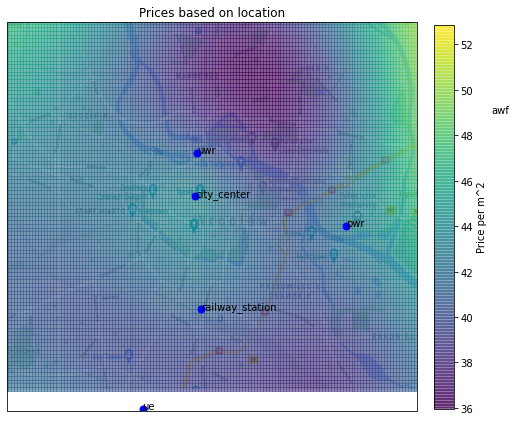

In [60]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Prices based on location')


img_extent = (16.997416, 17.105600, 51.092244, 51.126107)
img = plt.imread('img/wroclaw.png')
plt.pcolormesh(lon, lat, grid_values, transform=ccrs.PlateCarree(), alpha=0.6,
               cmap='viridis')
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())


for name, location in places.items():
    ax.plot(location[1], location[0], 'bo', markersize=7, transform=ccrs.PlateCarree())
    ax.text(location[1], location[0], name, transform=ccrs.PlateCarree())

ax.set_extent((16.997416, 17.072600, 51.090244, 51.126107), crs=ccrs.PlateCarree())
ax.set_aspect(1587.0/797)
plt.colorbar(label='Price per m^2', fraction=0.043, pad=0.04)
plt.show()